**Code reference:** https://debuggercafe.com/training-resnet18-from-scratch-using-pytorch/

## **Build ResNet-18**

In [ ]:
import torch.nn as nn
import torch

from torch import Tensor
from typing import Type

In [ ]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels
        # It is 1 for ResNet18 and ResNet34
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels*self.expansion,
            kernel_size=3,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return  out

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self,
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock`
            # to use to build the network and how many basic blocks to stack together
            layers = [2, 2, 2, 2]
            self.expansion = 1

        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)

    def _make_layer(
        self,
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

## **Utils**

In [ ]:
import matplotlib.pyplot as plt
import os

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

plt.style.use('ggplot')

In [ ]:
def get_data(batch_size=64):
    # CIFAR10 training dataset
    dataset_train = datasets.CIFAR10(
        root='data',
        train=True,
        download=True,
        transform=ToTensor(),
    )

    # CIFAR10 validation dataset
    dataset_valid = datasets.CIFAR10(
        root='data',
        train=False,
        download=True,
        transform=ToTensor(),
    )

    # Create data loaders
    train_loader = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        shuffle=False
    )
    return train_loader, valid_loader

In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if not os.path.exists('outputs'):
        os.makedirs('outputs')
    plt.savefig(os.path.join('outputs', name+'_accuracy.png'))

    # Loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', name+'_loss.png'))

## **Set up for training**

In [ ]:
from tqdm import tqdm

In [ ]:
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training...')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(image)
        # Calculate loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

    # Loss & accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(image)
            # Calculate loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss & accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

## **Training**

In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

In [ ]:
# Set seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

In [ ]:
epochs = 20
batch_size = 64
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_loader, valid_loader = get_data(batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:13<00:00, 12413164.03it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=10).to(device)
plot_name = 'ResNet-18'

In [ ]:
# Total parameters & trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.CrossEntropyLoss()

11,181,642 total parameters.
11,181,642 training parameters.


[INFO]: Epoch 1 of 20
Training...


100%|██████████| 782/782 [00:22<00:00, 35.10it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 86.89it/s]


Training loss: 1.419, training acc: 48.938
Validation loss: 1.735, validation acc: 42.380
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training...


100%|██████████| 782/782 [00:12<00:00, 60.23it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.03it/s]


Training loss: 1.023, training acc: 63.622
Validation loss: 1.859, validation acc: 44.040
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training...


100%|██████████| 782/782 [00:12<00:00, 60.20it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 88.10it/s]


Training loss: 0.840, training acc: 70.224
Validation loss: 1.261, validation acc: 57.970
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.90it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.57it/s]


Training loss: 0.705, training acc: 75.202
Validation loss: 1.197, validation acc: 60.970
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 60.07it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.12it/s]


Training loss: 0.600, training acc: 78.794
Validation loss: 1.704, validation acc: 50.400
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.41it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.46it/s]


Training loss: 0.497, training acc: 82.492
Validation loss: 1.287, validation acc: 60.940
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training...


100%|██████████| 782/782 [00:12<00:00, 60.22it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.77it/s]


Training loss: 0.414, training acc: 85.386
Validation loss: 2.073, validation acc: 49.800
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.99it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 88.55it/s]


Training loss: 0.339, training acc: 87.948
Validation loss: 1.078, validation acc: 68.080
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training...


100%|██████████| 782/782 [00:12<00:00, 60.48it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.12it/s]


Training loss: 0.274, training acc: 90.170
Validation loss: 1.428, validation acc: 63.320
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.54it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 85.72it/s]


Training loss: 0.234, training acc: 91.688
Validation loss: 1.311, validation acc: 66.250
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training...


100%|██████████| 782/782 [00:12<00:00, 60.57it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.18it/s]


Training loss: 0.192, training acc: 93.180
Validation loss: 1.580, validation acc: 63.080
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 60.11it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.58it/s]


Training loss: 0.153, training acc: 94.632
Validation loss: 1.419, validation acc: 67.210
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.89it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 86.04it/s]


Training loss: 0.140, training acc: 95.022
Validation loss: 1.767, validation acc: 62.620
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.87it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 86.96it/s]


Training loss: 0.115, training acc: 96.054
Validation loss: 1.714, validation acc: 64.270
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 58.84it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 86.91it/s]


Training loss: 0.096, training acc: 96.580
Validation loss: 1.886, validation acc: 61.890
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 60.07it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 86.55it/s]


Training loss: 0.086, training acc: 96.952
Validation loss: 2.594, validation acc: 55.570
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 60.06it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.58it/s]


Training loss: 0.072, training acc: 97.436
Validation loss: 1.378, validation acc: 71.910
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training...


100%|██████████| 782/782 [00:12<00:00, 60.21it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 88.25it/s]


Training loss: 0.061, training acc: 97.878
Validation loss: 1.408, validation acc: 72.290
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.76it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.21it/s]


Training loss: 0.064, training acc: 97.794
Validation loss: 1.357, validation acc: 72.630
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training...


100%|██████████| 782/782 [00:13<00:00, 59.27it/s]


Validation


100%|██████████| 157/157 [00:01<00:00, 87.26it/s]


Training loss: 0.044, training acc: 98.514
Validation loss: 1.531, validation acc: 70.800
--------------------------------------------------
TRAINING COMPLETE


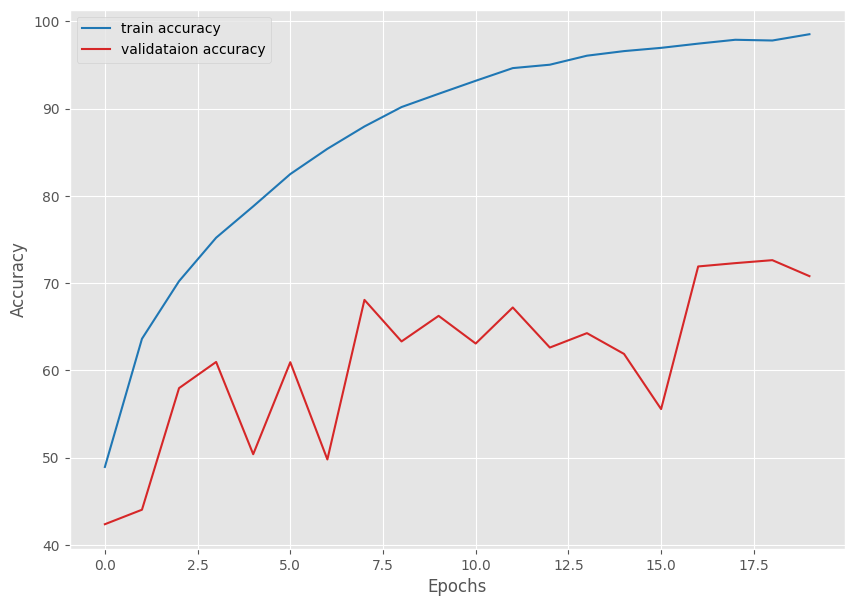

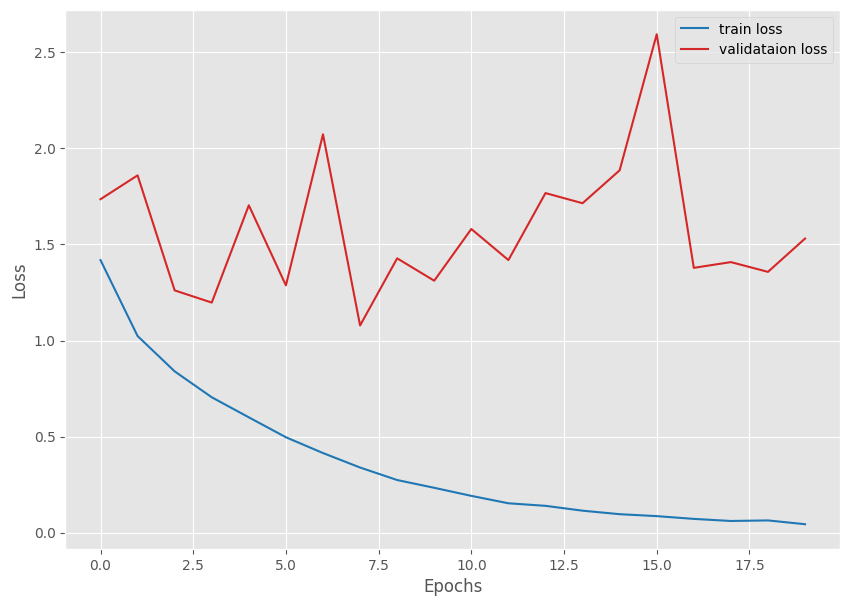

In [ ]:
# Lists to keep track of losses & accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# Start training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model,
                                              train_loader,
                                              optimizer,
                                              criterion,
                                              device)
    valid_epoch_loss, valid_epoch_acc = validate(model,
                                                 valid_loader,
                                                 criterion,
                                                 device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

# Save the loss & accuracy plots
save_plots(train_acc,valid_acc, train_loss, valid_loss, name=plot_name)
print('TRAINING COMPLETE')